In [1]:
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
from helpers import SemiSupervisedDataset
from helpers import train, evaluation, generate_confusion_matrix
from helpers import plot_accuracy, plot_loss, plot_confusion_matrix

In [2]:
DATA_PATH = './15SceneData/'
MODELS_PATH = './models/'
PLOTS_PATH = './plots/'
MODEL_NAME = 'perturbation_v1'

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

NUM_CLASSES = 2
BATCH_SIZE = 32
NUM_EPOCHS = 30
PATIENCE = 5

In [3]:
# Load via custom function that returns perturbed dataset
train_dataset = SemiSupervisedDataset(
    DATA_PATH + 'train',
    image_transformation='black-white',
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])
)

val_dataset = SemiSupervisedDataset(
    DATA_PATH + 'validation',
    image_transformation='black-white',
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])
)

In [4]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [5]:
model = models.efficientnet_b0(weights='IMAGENET1K_V1')

# Change the classifier part of model to fit our problem
print('BEFORE:', model.classifier)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(1280, NUM_CLASSES)
)
print('AFTER:', model.classifier)

BEFORE: Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
AFTER: Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)


In [6]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

fitted, train_loss, train_acc, val_loss,  val_acc = train(
    model, 
    optimizer,
    loss_fn,
    train_loader, 
    val_loader, 
    lr_scheduler=lr_scheduler,
    num_epochs=NUM_EPOCHS, 
    patience=PATIENCE, 
    device=DEVICE
    )

torch.save(fitted, MODELS_PATH + MODEL_NAME + '.pt')

Epoch [10/30]: 100%|██████████| 94/94 [00:35<00:00,  2.67it/s, train_acc=99.1, train_loss=0.0247, val_acc=99.5, val_loss=0.0114]


Early stopping!


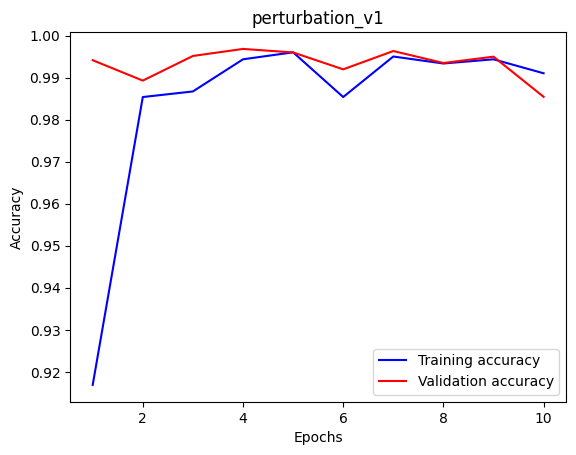

In [7]:
plot_accuracy(train_acc, val_acc, MODEL_NAME, PLOTS_PATH + MODEL_NAME + '_accuracy.png')

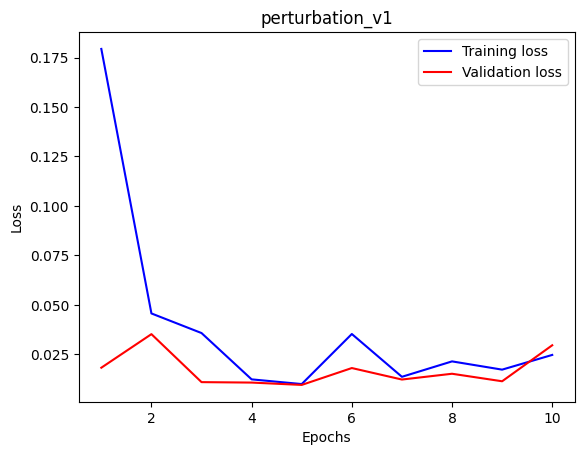

In [8]:
plot_loss(train_loss, val_loss, MODEL_NAME, PLOTS_PATH + MODEL_NAME + '_loss.png')

In [9]:
_, train_accuracy = evaluation(fitted, train_loader, nn.CrossEntropyLoss(), DEVICE)
_, val_accuracy = evaluation(fitted, val_loader, nn.CrossEntropyLoss(), DEVICE)

print(f'Train accuracy: {train_accuracy*100.:.2f}%')
print(f'Validation accuracy: {val_accuracy*100.:.2f}%')

Train accuracy: 99.77%
Validation accuracy: 99.51%


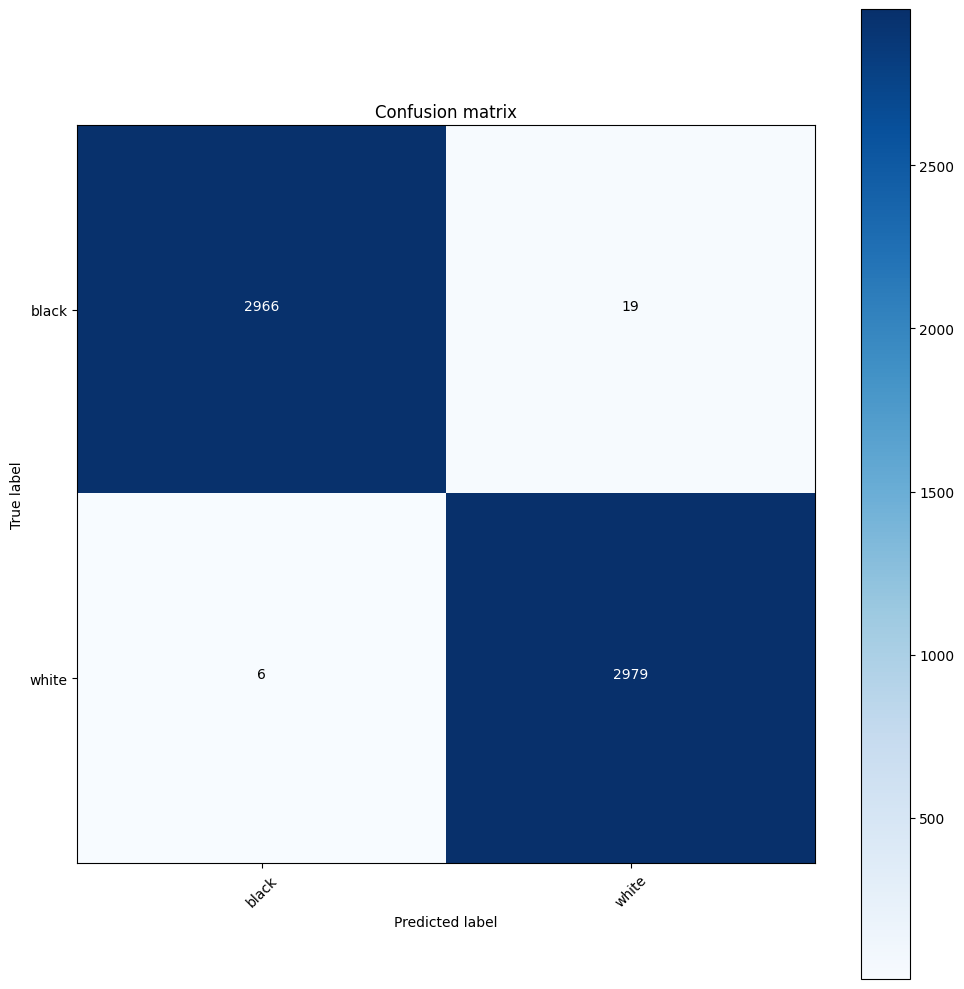

In [10]:
cm = generate_confusion_matrix(fitted, val_loader, DEVICE)

plot_confusion_matrix(
    cm,
    val_loader.dataset.classes,
    'Confusion matrix',
    PLOTS_PATH + MODEL_NAME + '_confusion_matrix.png',
    normalize=False
)